In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42155/status,
Dashboard: /proxy/42155/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32989,Workers: 4
Dashboard: /proxy/42155/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43495,Total threads: 2
Dashboard: /proxy/46299/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37201,


In [3]:
session = cc.database.create_session()

In [4]:
# load control experiment
umo_con = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='tx_trans', 
                          session=session, frequency='1 monthly',
                          start_time='1950-01-31 00:00:00', 
                          end_time='2179-12-31 00:00:00').sel(yt_ocean = slice(-90,-50))

In [5]:
# load easterlies down experiment
umo_down = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_easterlies_down10', variable='tx_trans', 
                          session=session, frequency='1 monthly',
                          start_time='2150-01-31 00:00:00', 
                          end_time='2164-12-31 00:00:00').sel(yt_ocean = slice(-90,-50))

In [6]:
# load easterlies up experiment
umo_up = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_easterlies_up10', variable='tx_trans', 
                          session=session, frequency='1 monthly',
                          start_time='2150-01-31 00:00:00', 
                          end_time='2164-12-31 00:00:00').sel(yt_ocean = slice(-90,-50))

### total streamfunction from 2160-2164

In [7]:
# set time period
start_time = '2160-01-01'
end_time = '2165-01-01'

In [13]:
flux1 = (umo_con.sel(time = slice(start_time,end_time)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

In [14]:
flux2 = (umo_down.sel(time = slice(start_time,end_time)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

In [15]:
flux3 = (umo_up.sel(time = slice(start_time,end_time)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

Text(0.5, 0, 'streamfunction (Sv)')

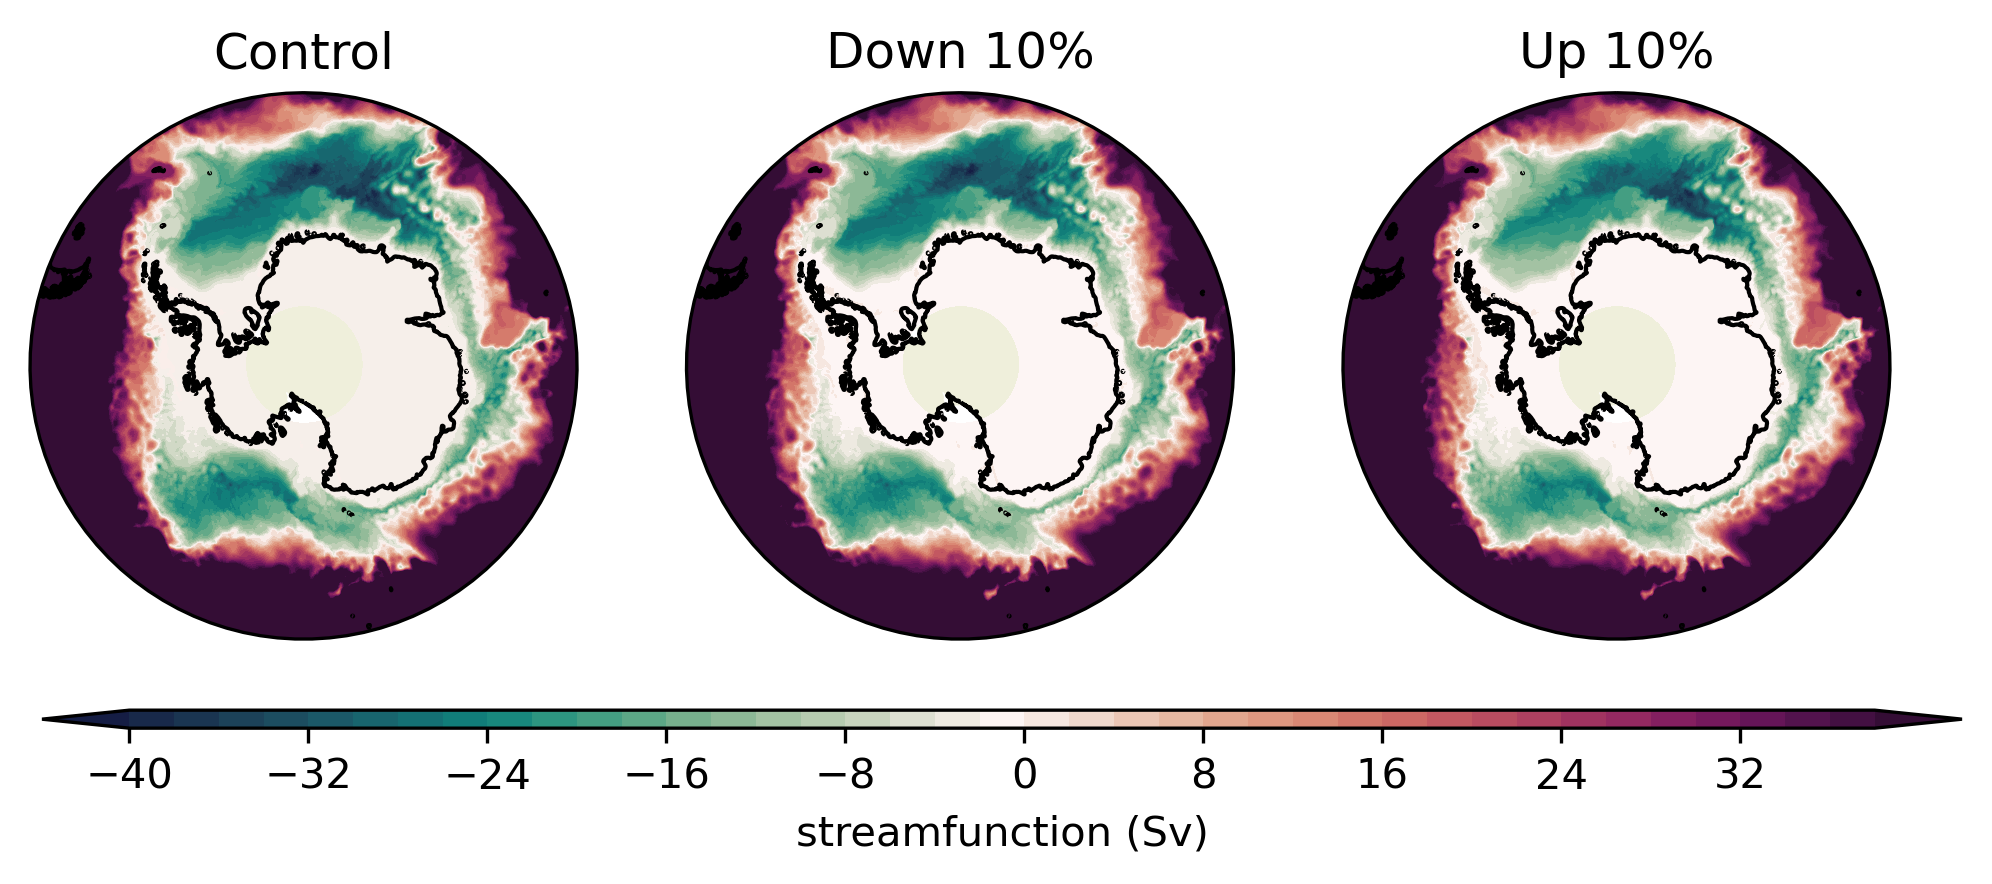

In [17]:
# plot the results
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 3), dpi=300)
# control
ax = plt.subplot(1,3,1,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux1.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Control')

# down 10%
ax = plt.subplot(1,3,2,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux2.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Down 10%')

# up 10% 
ax = plt.subplot(1,3,3,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux3.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Up 10%')

# add the colorbar
ax = plt.axes([0.13, 0.1, 0.8, 0.02])
cb = plt.colorbar(p1, cax=ax, orientation='horizontal',extend = 'both')
cb.ax.set_xlabel('streamfunction (Sv)')

### At different depth layers

In [18]:
# control
flux11 = (umo_con.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(0,1000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux12 = (umo_con.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(1000,2000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux13 = (umo_con.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(2000,3000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux14 = (umo_con.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(3000,4000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [19]:
# down
flux21 = (umo_down.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(0,1000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux22 = (umo_down.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(1000,2000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux23 = (umo_down.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(2000,3000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux24 = (umo_down.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(3000,4000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

In [20]:
# up
flux31 = (umo_up.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(0,1000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux32 = (umo_up.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(1000,2000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux33 = (umo_up.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(2000,3000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()
flux34 = (umo_up.sel(time = slice(start_time,end_time)).sel(st_ocean = slice(3000,4000)).mean('time').cumsum('yt_ocean').sum('st_ocean')/1e9).load()

Text(0.5, 0, 'streamfunction (Sv)')

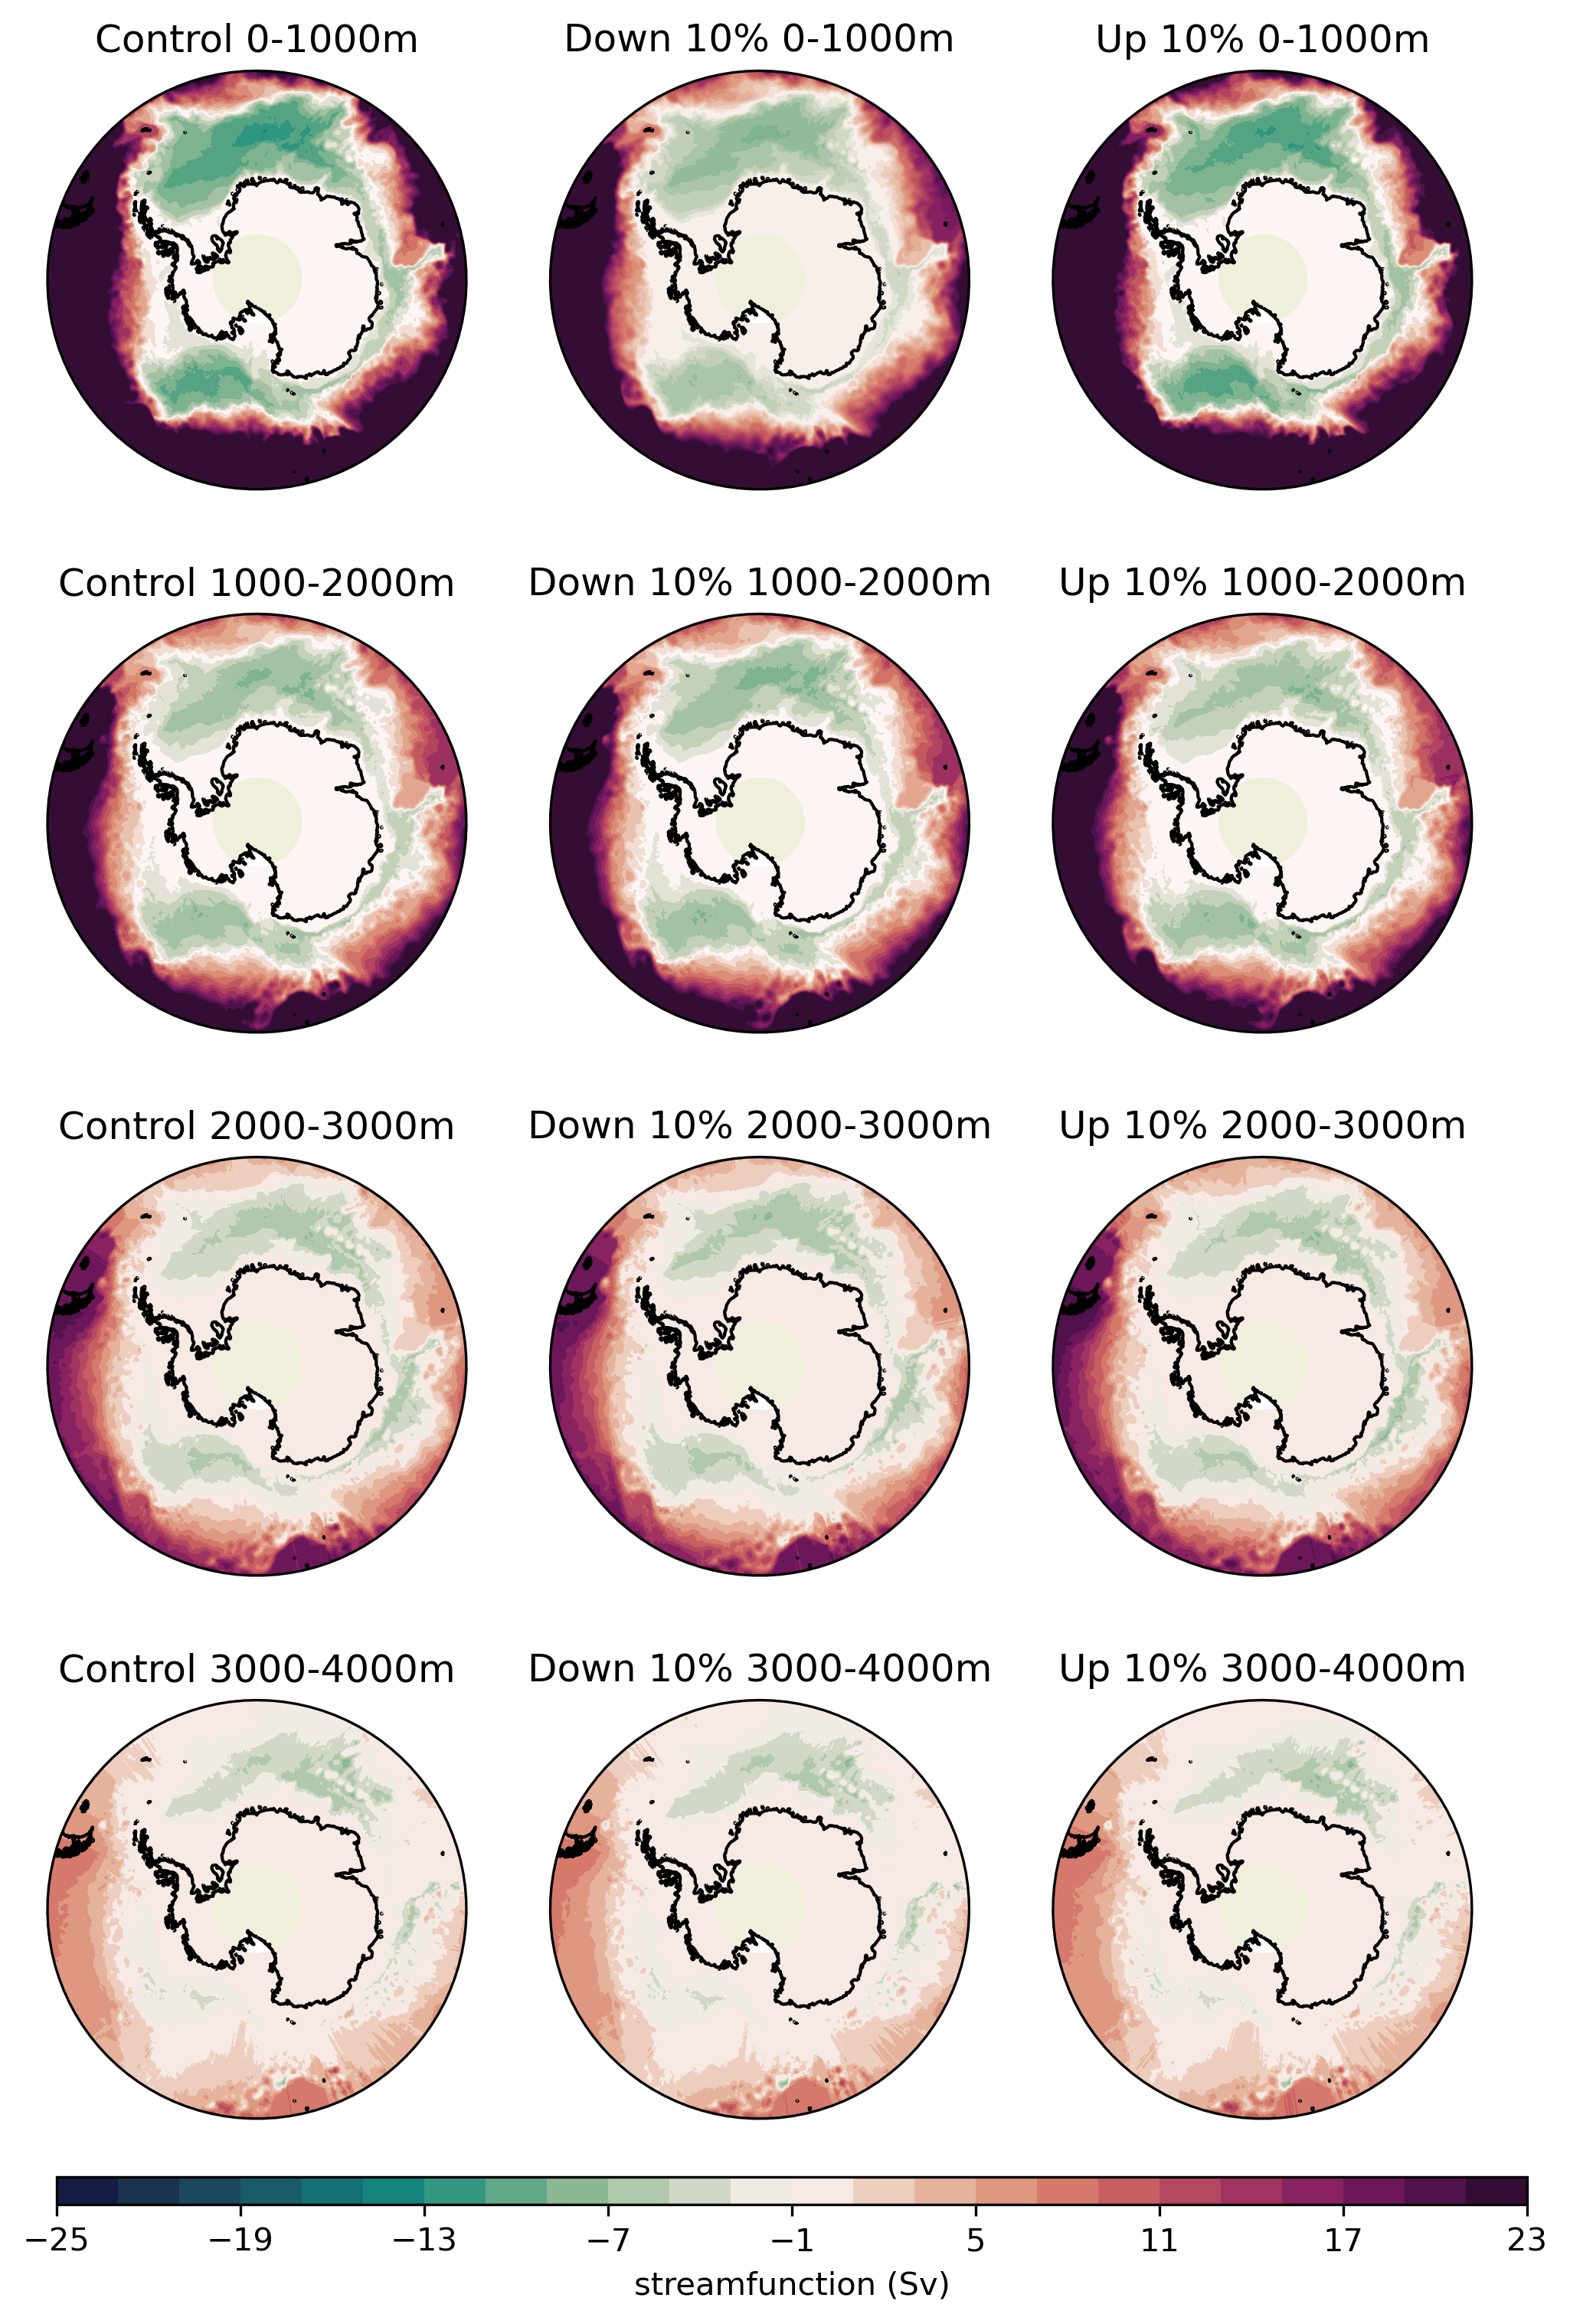

In [22]:
# plot the results
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 12), dpi=300)
# 0-1000
ax = plt.subplot(4,3,1,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux11.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Control 0-1000m')

ax = plt.subplot(4,3,2,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux21.plot.contourf(ax=ax, levels = np.arange(-40,40,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Down 10% 0-1000m')

ax = plt.subplot(4,3,3,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux31.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Up 10% 0-1000m')

# 1000-2000 
ax = plt.subplot(4,3,4,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux12.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Control 1000-2000m')

ax = plt.subplot(4,3,5,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux22.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Down 10% 1000-2000m')

ax = plt.subplot(4,3,6,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux32.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Up 10% 1000-2000m')

# 2000-3000m
ax = plt.subplot(4,3,7,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux13.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Control 2000-3000m')

ax = plt.subplot(4,3,8,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux23.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Down 10% 2000-3000m')

ax = plt.subplot(4,3,9,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux33.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Up 10% 2000-3000m')

# 3000-4000 m
ax = plt.subplot(4,3,10,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux14.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Control 3000-4000m')

ax = plt.subplot(4,3,11,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux24.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Down 10% 3000-4000m')

ax = plt.subplot(4,3,12,projection = projection)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux34.plot.contourf(ax=ax, levels = np.arange(-25,25,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl, add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.set_title('Up 10% 3000-4000m')
# add the colorbar
ax = plt.axes([0.13, 0.1, 0.8, 0.01])
cb = plt.colorbar(p1, cax=ax, orientation='horizontal',extend = 'both')
cb.ax.set_xlabel('streamfunction (Sv)')